In [1]:
using Pkg; Pkg.activate("../.")
using Revise
using QuadrupedBalance
using TOML
using RobotDynamics
using LinearAlgebra
using OSQP
using SparseArrays
using ControlSystems
using RigidBodyDynamics
using Rotations
using PyPlot
using MeshCat
using MeshCatMechanisms
using StaticArrays
using DelimitedFiles
const QB = QuadrupedBalance
const RD = RobotDynamics

WebIO._IJuliaInit()

  Activating project at `~/dev/QuadrupedBalance.jl`
┌ Warning: You are using Matplotlib 3.1.2, which is no longer
│ officialy supported by the Plots community. To ensure smooth Plots.jl
│ integration update your Matplotlib library to a version >= 3.4.0
│ 
│ If you have used Conda.jl to install PyPlot (default installation),
│ upgrade your matplotlib via Conda.jl and rebuild the PyPlot.
│ 
│ If you are not sure, here are the default instructions:
│ 
│ In Julia REPL:
│ ```
│ import Pkg;
│ Pkg.add("Conda")
│ import Conda
│ Conda.update()
│ Pkg.build("PyPlot")
│ ```
│ 
└ @ Plots /home/chiyen/.julia/packages/Plots/Zuo5g/src/backends/pyplot.jl:29
┌ Warning: You are using Matplotlib 3.1.2, which is no longer
│ officialy supported by the Plots community. To ensure smooth Plots.jl
│ integration update your Matplotlib library to a version >= 3.4.0
│ 
│ If you have used Conda.jl to install PyPlot (default installation),
│ upgrade your matplotlib via Conda.jl and rebuild the PyPlot.
│ 
│ If you ar

RobotDynamics

## Simulation

In [970]:
#### Loading eq point, and setting which foot are in contacts 
data = TOML.parsefile("ipopt_eq_point2.toml") # load eq point 
x_eq = data["x_eq"];
u_eq = data["u_eq"];
λ_eq = data["λ_eq"];

urdfpath = joinpath(@__DIR__, "..", "src","a1","urdf","a1_light.urdf")
A1mech = parse_urdf(urdfpath, floating=true, remove_fixed_tree_joints=false)
A1 = QuadrupedBalance.UnitreeA1FullBody(A1mech);
foot_contacts = [1, 0, 0, 1] # FR, FL, RR, RL
foot_indices = []            # specifies which foot constraints are active 
for i in 1:length(foot_contacts)
    if(foot_contacts[i] == 1)
        append!(foot_indices, (i-1)*3 .+ (1:3))
    end 
end 

In [1663]:
#### Simulation and helper Functions 
"""Take a single semi-implicit euler integration step. Returns x_next and λ"""
function semi_implicit_euler(A1::QB.AbstractQuadruped, x::AbstractVector, u::AbstractVector, ϕ_cons::AbstractVector, foot_indices, h)
    xn = copy(x)
    
    # Mass matrix and dynamics bias 
    M = QB.get_mass_matrix(A1, xn)
    C_dyn = QB.get_dynamics_bias(A1, xn)
    
    # Kinematic Jacobian 
    attitude_error_jacobian = blockdiag(0.5*sparse(QuadrupedBalance.quaternion_differential(x[1:4])),
                                        sparse(Rotations.UnitQuaternion(x[1:4])),
                                        sparse(I(30)) )
    J = QB.dfk_world(x)[foot_indices,:] * attitude_error_jacobian
    J = J[:, 1:18]
    ϕ = QB.fk_world(xn)[foot_indices]

    v_dim = num_velocities(A1.rigidbody.mech)
    p_dim = num_positions(A1.rigidbody.mech)
    
    ## Solving for velocities 
    damp = 0.0
    r = [([zeros(6);u].-C_dyn - [zeros(6);damp*xn[p_dim+6+1:end]])*h.+M*xn[p_dim+1:end]; -ϕ+ϕ_cons] # KKT conditions 
    H = zeros(v_dim+length(foot_indices), v_dim+length(foot_indices))  
    H[1:v_dim,1:v_dim] .= M 
    H[1:v_dim,v_dim+1:end] .= J'*h 
    H[v_dim+1:end, 1:v_dim] .= J*h
    δ = H \ r

    v_next = δ[1:v_dim]
    λ = δ[v_dim+1:end]

    ## Integrating 
    rot = UnitQuaternion(xn[1:4])
    v_trans = rot * v_next[4:6]   
    xn[5:7] = xn[5:7] + v_trans * h
    xn[8:p_dim] .= xn[8:p_dim] + v_next[7:end] *h


    # Update attitude
    q_dot = 0.5*QB.get_G(x[1:4])*v_next[1:3]*h
    xn[1:4] .= QB.L(xn[1:4]) * QB.ρ(v_next[1:3]*h)
    xn[1:4] .= xn[1:4]/norm(x[1:4])
    xn[p_dim+1:end] .= v_next 
    return xn, λ
end 

function joint_pd_control(q, q_des, q_v, Kp, Kd)
    q_diff = q - q_des 
    u = -Kp .* q_diff - Kd .* q_v 
end 

joint_pd_control (generic function with 1 method)

## Controller

In [1664]:
mutable struct Controller 
    s_des::Vector # desired state 
    f_des::Vector # desired control vector 
    A::Matrix     # Linearized state transition jacobian
    B::Matrix     # Linearized control jacobian
    Q::Matrix     # LQR gain
    R::Matrix     # LQR regularization
    P::Matrix
    h::Float64    # time step size    
end

In [1665]:
""" QP that solves grnd reaction forces"""
function eq_point_qp(model, problem, s, foot_indices)  
    num_feet = Int(length(foot_indices)/3)
    
    ## Matrices that map grnd reaction to body frame
    rot = QB.H'QB.L(s[7:10])*QB.R(s[7:10])'QB.H #Rotation matrix
    r̂1 = rot'*QB.hat((model.p1-s[1:3])) # rotate to body frame
    r̂2 = rot'*QB.hat((model.p2-s[1:3]))
    r̂3 = rot'*QB.hat((model.p3-s[1:3]))
    r̂4 = rot'*QB.hat((model.p4-s[1:3]))
    M = [I(3) I(3) I(3) I(3);
         r̂1   r̂2    r̂3   r̂4]
    M = M[:,foot_indices]
    g = [0, 0, -9.81]
    b = [model.m * g; zeros(3)] # Desired translation + rotational acceleration
    
    ## QP matrix and vector weightd 
    W = Diagonal(ones(6))
    P = M' * W * M + 1e-5*I(length(foot_indices))
    q = b' * W * M
    
    ## Frriction constraints
    μ = 0.6
    c = [1 0 1/sqrt(2)*μ; 
         0 1 -1/sqrt(2)*μ]
    C= kron(I(num_feet), c)
    lower = kron(ones(num_feet),[0, -Inf])
    upper = kron(ones(num_feet),[Inf, 0])
#     OSQP.setup!(problem, P=P, q=q', A=sparse(C), l=lower, u=upper, verbose=0)
    OSQP.setup!(problem, P=P, q=q', verbose=0)
    results = OSQP.solve!(problem)
    return results.x, C, M
end

function ricatti(A, B, Q, R)
    P = copy(Q)
    P_prev = zero(P)
    K = zeros(size(B'))
    res = norm(P-P_prev)
    while res > 1e-7
        K = (R + B'*P_prev*B)\ B'*P*A
        P = Q + A'*P_prev*(A-B*K)
        res = norm(P-P_prev)
        P_prev = copy(P)
    end
    return P, K
end

"""Get unconstrained cost to go given eq point and grnd reaction forces """
function uctg(model, Q, R, s_des, f_eq, foot_indices, h)
    ## Linearize jacobian
    A, B = QB.dynamics_jacobians_discrete(model, s_des, f, h)
    xn = QB.dynamics_rk4(model, s_des, f, h)
    G = blockdiag(sparse(1.0I(6)), 
              sparse(QB.quaternion_differential(s_des[7:10])), 
              sparse(1.0I(3)))
    Gn = blockdiag(sparse(1.0I(6)), 
              sparse(QB.quaternion_differential(xn[7:10])), 
              sparse(1.0I(3)))
    A = Gn' * A * G 
    B = Gn' * B 
    B = B[:,foot_indices]
#     P_uctg = ControlSystems.dare(A,B,Q,R) # unconstrained ctg hessian
    P_uctg, K = ricatti(A, B, Q, R)
    return P_uctg, A, B, K
end

""" """
function qp_controller(model, problem, controller, s, joints, f_prev, foot_indices)
    num_feet = Int(length(foot_indices)/3)
    rot = QB.H'QB.L(s[7:10])*QB.R(s[7:10])'QB.H #Rotation matrix

    ## error calculation
    δs = zeros(12)
    δs[1:6]   = s[1:6]   - controller.s_des[1:6]
    δs[10:12] = s[11:13] - controller.s_des[11:13]
    q_diff = QB.L(controller.s_des[7:10])' * s[7:10]
    ϕ = q_diff[2:4] / q_diff[1]
    δs[7:9] = ϕ 
    
    μ = 0.6  # friction
    β = 0.00   # smoothing factor
    f_eq = controller.f_des
    A = controller.A
    B = controller.B
    Q = controller.Q
    R = controller.R
    P_uctg = controller.P
    
    W = sparse(R + B' * P_uctg * B + β*I(num_feet*3))
    q = (B' * P_uctg * A * δs)' - f_prev' * β*I(num_feet*3)
    C = [1 0  1/sqrt(2)*μ 0 0 0;
         0 1 -1/sqrt(2)*μ 0 0 0;
         0 0 0            1 0  1/sqrt(2)*μ;
         0 0 0            0 1 -1/sqrt(2)*μ;
         0 0 1            0 0  0 ;
         0 0 0            0 0  1]
    lower = [-1/sqrt(2)*μ*f_eq[3]-f_eq[1], -Inf,  -1/sqrt(2)*μ*f_eq[12]-f_eq[10], -Inf, -f_eq[3], -f_eq[12]]
    upper = [Inf,1/sqrt(2)*μ*f_eq[3]-f_eq[2], Inf, 1/sqrt(2)*μ*f_eq[12]-f_eq[11], 150-f_eq[3], 150-f_eq[12]]
#     C = [
#          0 0 1            0 0  0 ;
#          0 0 0            0 0  1]
#     lower = [ -f_eq[3], -f_eq[12]]
#     upper = [ 150-f_eq[3], 150-f_eq[12]]
    OSQP.setup!(problem, P=W, q=q', A=sparse(C), l=lower, u=upper, verbose=0, eps_abs=1e-6, eps_rel=1e-6)
#     OSQP.setup!(problem, P=W, q=q', verbose=0)
    results = OSQP.solve!(problem)
    f = results.x     
#     f = -K * δs
    return f, δs
end

"""Convert 37 full state to a 13 state centroidal state"""
function full2centroidal(x_full)
    rot = QB.H'QB.L(x_full[1:4])*QB.R(x_full[1:4])'QB.H #Rotation matrix

    x_centroid = zeros(13)
    x_centroid[1:3] = x_full[5:7]
    x_centroid[4:6] = rot * x_full[23:25]
    x_centroid[7:10] = x_full[1:4]
    x_centroid[11:13] = rot' * x_full[20:22]
    return x_centroid
end


let
    I_inertia = Matrix(Diagonal([0.08, 0.3, 0.36]))
    m = 12.454 # mass 
    x = copy(x_eq)
    p = QB.fk_world(x)
    model = QB.CentroidalModel(I_inertia, m, p[1:3], p[4:6], p[7:9], p[10:12])
    num_feet = Int(length(foot_indices)/3)
    
    ## init qp solvers 
    problem1 = OSQP.Model()
    problem2 = OSQP.Model()
    
    ## Find ground reaction forces and equivalent forces 
    s_des = zeros(13)
    s_des[7:10] = [1.0, 0.0, 0.0, 0.0]
    α = 1/3
#     s_des[1:3].= (p[1:3] *α + p[10:12]*(1-α) + p[7:9]*α) # midway between foot position
    s_des[1:3] = p[1:3] *0.5 + p[10:12]*0.5
    s_des[3] = 0.3

    f_des, C, M = eq_point_qp(model, problem1, s_des, foot_indices)
    ## Caculate uctg and init controller
    h = 0.001
    Q = Matrix(Diagonal([10., 10., 10000., 1.0, 1.0, 10., 1600, 1800, 1500., 10., 5, 1.])) *1e-2
    R = Matrix(Diagonal(kron(ones(num_feet), [0.5, 0.5, .5]))) * 1e-2 * 1e-3
    f = zeros(12); f[foot_indices] = f_des
    P_uctg, A, B, _ = uctg(model, Q, R, s_des, f_des, foot_indices, h) 
    controller = Controller(s_des, f, A, B, Q, R, P_uctg, h)
    
    ## Calculate control
    sn = copy(s_des)
    sn[2] += 0.001
    sn[7:10] = QB.L(sn[7:10]) * (QB.ρ([0.0,0.,0.0]))
    f, δs = qp_controller(model, problem2, controller, sn, x_eq[8:19], zeros(12), foot_indices)
end

LoadError: DimensionMismatch("")

In [1666]:
### Setting up the controller 
I_inertia = Matrix(Diagonal([0.05, 0.1, 0.25]))
# I_inertia = Matrix(Diagonal([0.025, 0.08, 0.12]))
m = 12.54 # mass 
x = copy(x_eq)
p = QB.fk_world(x)
num_feet = Int(length(foot_indices)/3)
model = QB.CentroidalModel(I_inertia, m, p[1:3], p[4:6], p[7:9], p[10:12])
## init qp solvers 
problem1 = OSQP.Model()
problem2 = OSQP.Model()

## Find ground reaction forces and equivalent forces 
s_des = zeros(13)
s_des[7:10] = [1.0, 0.0, 0.0, 0.0]
α = 1/3
# s_des[1:3].= (p[1:3] *α + p[10:12]*(1-α) + p[7:9]*α) # midway between foot position
# s_des[1:3] = p[1:3] *0.5 + p[10:12]*0.5; 
s_des[1:3] = x_eq[5:7]
s_des[3] = x_eq[7] 
s_des[7:10] = QB.L(s_des[7:10]) * QB.ρ([0.0,0.0,0.0])
f_des, C, M = eq_point_qp(model, problem1, s_des, foot_indices)

## Caculate uctg and init controller
h = 0.001
Q = Matrix(Diagonal([20, 20, 10000, 1, 1, 1, 1100, 1600, 100., 10., 50, 1.])) * 1e-2
R = Matrix(Diagonal(kron(ones(num_feet), [1.25, 1.25, .5]))) * 1e-4
f = zeros(12); f[foot_indices] = f_des
P_uctg, A, B, K = uctg(model, Q, R, s_des, f, foot_indices, h)
controller = Controller(s_des, f, A, B, Q, R, P_uctg, h);

In [1667]:
###### Simulation Loop ######
n = length(x_eq)
m = 12
h = 0.001
tf = 4.0
times = 0:h:tf
ϕ_cons = QB.fk_world(x_eq)[foot_indices] # feet constraint 
ind_fixed = [2,6,10, 3, 7, 11]
# Loop variables 
xs = zeros(length(times), n)
ss = zeros(length(times), 13)
us = zeros(length(times), m)
fs = zeros(length(times), 12)
λs = zeros(length(times), num_feet*3)
δss = zeros(length(times), 12) 
xs[1,:] = copy(x_eq)
fs[1,:] = zeros(12)
us[1,:] = -QB.dfk_world(x_eq)[:,8:19]' * controller.f_des
# xs[1,23] += -0.05
# xs[1,24] += -0.02

ss[1,:] = full2centroidal(xs[1,:])
resting_joints = x_eq[8:19] #[ones(4)*0.0; ones(4)*1.2; -ones(4)*2.2]
s_des[7:10] = QB.L([1,0,0,0]) * QB.ρ([0.,0,0])
com_offset = [-x_eq[5], -x_eq[6], 0.0]*0 # breaks after 0.01 shifts in any direction
for i in 1:length(times) - 1
    ## get sensor 
    encs = xs[i, 8:19]
    joint_vels = xs[i, 26:end]
    pos = xs[i,5:7]
    v = xs[i,23:25]
    ω = xs[i,20:22]
    quat_meas = UnitQuaternion(xs[i,1:4])
    quat_eq = UnitQuaternion(x_eq[1:4])
    
    ## Feedback control 
    fk_cons = QB.fk_world(x_eq)[foot_indices] # feet constraint 
    sn = full2centroidal(xs[i,:])
#     sn[1:2] -= x_eq[5:6]  #- (quat_meas' * com_offset)
    sn[1:3] += (quat_meas * com_offset)
    u_joint = joint_pd_control(encs, x_eq[8:19], joint_vels, 100, 1)
    f, δs = qp_controller(model, problem2, controller, sn, encs, fs[i,:], foot_indices)

#     if i > 2000
#         s_des[7:10] = QB.L([1,0,0,0]) * QB.ρ([0., 0, deg2rad(10)])
#     end
    rot = QB.H'QB.L(sn[7:10])*QB.R(sn[7:10])'QB.H #Rotation matrix
    rot = kron(I(4), rot')
    
    fs[i+1,foot_indices] .= f
    us[i+1,:] = -QB.dfk(encs)[:,:]' * rot* (fs[i,:] + controller.f_des) 
    us[i+1,ind_fixed] = u_joint[ind_fixed] 
    δss[i,:] = δs

    
    xs[i+1, :], λs[i+1,:] = semi_implicit_euler(A1, xs[i,:], us[i+1,:], ϕ_cons, foot_indices, h)
    ss[i+1,:] = full2centroidal(xs[i+1,:])

end

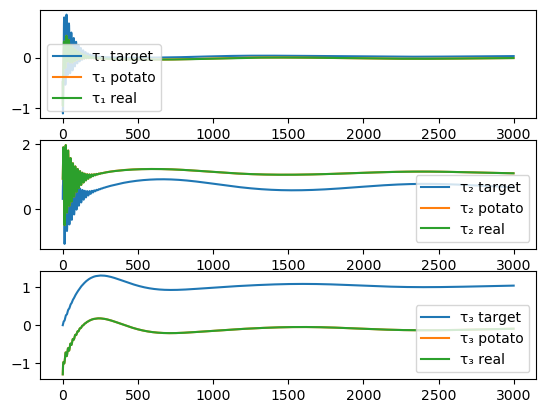

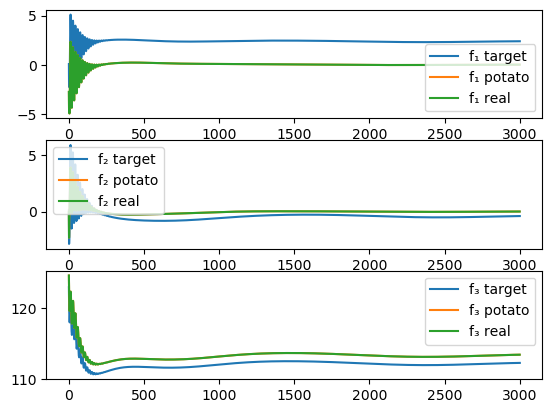

PyObject <matplotlib.legend.Legend object at 0x7faf23ea6220>

In [1668]:
let 
    ## calculate desired net forces 
    f_sum_des = zeros(length(times),6)
    f_sum_potato = zeros(length(times), 6)
    f_sum_meas = zeros(length(times), 6)
    com_offset = [-0.005, 0.0008, 0.0] *0 # breaks after 0.01 shifts in any direction
    
    rot = QB.H'QB.L(s_des[7:10])*QB.R(s_des[7:10])'QB.H #Rotation matrix

    pos = s_des[1:3] + rot * com_offset 
    r̂1 = QB.hat((model.p1-pos)) # rotate to body frame
    r̂2 = QB.hat((model.p2-pos))
    r̂3 = QB.hat((model.p3-pos))
    r̂4 = QB.hat((model.p4-pos))
    M = [I(3) I(3) I(3) I(3);
         rot'*r̂1   rot'*r̂2    rot'*r̂3   rot'*r̂4]
    τ_eq = M * controller.f_des
    for i in 1:size(λs,1)
        rot = QB.H'QB.L(ss[i,7:10])*QB.R(ss[i,7:10])'QB.H #Rotation matrix
#         rot = QB.H'QB.L(s_des[7:10])*QB.R(s_des[7:10])'QB.H #Rotation matrix

        pos = ss[i,1:3] + rot * com_offset 
        r̂1 = QB.hat((model.p1-pos)) # rotate to body frame
        r̂2 = QB.hat((model.p2-pos))
        r̂3 = QB.hat((model.p3-pos))
        r̂4 = QB.hat((model.p4-pos))
        M = [I(3) I(3) I(3) I(3);
             rot'*r̂1   rot'*r̂2    rot'*r̂3   rot'*r̂4]

        attitude_error_jacobian = blockdiag(sparse(0.5*QuadrupedBalance.quaternion_differential(xs[i,1:4])),
                                        sparse(I(33)) )
        x_shifted =copy(xs[i,:])
        J = QB.dfk_world(x_shifted)[foot_indices,:] * attitude_error_jacobian
        J = J[:, 1:18]
        wrench =  -J'*λs[i,:]
        wrench_des = J'* (fs[i,foot_indices] + controller.f_des[foot_indices])
        f_sum_meas[i,:] = [wrench[4:6];wrench[1:3]] 
        f_sum_des[i,:] = [wrench_des[4:6];wrench_des[1:3]]
        f_sum_potato[i,:] = -M[:,foot_indices] * λs[i,:] 

    end 
    t_ind = length(times) - 1000
    subplot(3,1,1)
    plot(f_sum_des[1:t_ind, 4], label="τ₁ target")
    plot(f_sum_potato[2:t_ind,4], label="τ₁ potato")
    plot(f_sum_meas[2:t_ind, 4], label="τ₁ real")
    legend()
    
    subplot(3,1,2)
    plot(f_sum_des[1:t_ind, 5], label="τ₂ target")
    plot(f_sum_potato[2:t_ind,5], label="τ₂ potato")
    plot(f_sum_meas[2:t_ind, 5], label="τ₂ real")
    legend()
    
    subplot(3,1,3)
    plot(f_sum_des[1:t_ind, 6], label="τ₃ target")
    plot(f_sum_potato[2:t_ind,6], label="τ₃ potato")
    plot(f_sum_meas[2:t_ind, 6], label="τ₃ real")
    legend()

    figure(2)
    subplot(3,1,1)
    plot(f_sum_des[1:t_ind, 1], label="f₁ target")
    plot(f_sum_potato[2:t_ind,1], label="f₁ potato")
    plot(f_sum_meas[2:t_ind, 1], label="f₁ real")
    legend()
    
    subplot(3,1,2)
    plot(f_sum_des[1:t_ind, 2], label="f₂ target")
    plot(f_sum_potato[2:t_ind,2], label="f₂ potato")
    plot(f_sum_meas[2:t_ind, 2], label="f₂ real")
    legend()
    
    subplot(3,1,3)
    plot(f_sum_des[1:t_ind, 3], label="f₃ target")
    plot(f_sum_potato[2:t_ind,3], label="f₃ potato")
    plot(f_sum_meas[2:t_ind, 3], label="f₃ real")
    legend()
end 

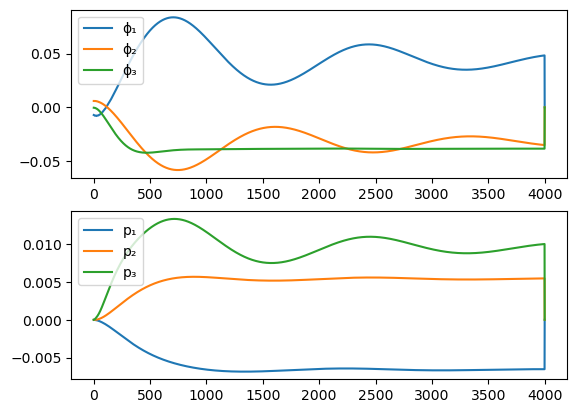

PyObject <matplotlib.legend.Legend object at 0x7faf23c98dc0>

In [1670]:
t_ind = length(times) 
subplot(2,1,1)
plot(δss[1:t_ind,7],label="ϕ₁")
plot(δss[1:t_ind,8],label="ϕ₂")
plot(δss[1:t_ind,9],label="ϕ₃")
legend()

subplot(2,1,2)
plot(δss[1:t_ind,1],label="p₁")
plot(δss[1:t_ind,2],label="p₂")
plot(δss[1:t_ind,3],label="p₃")
legend()

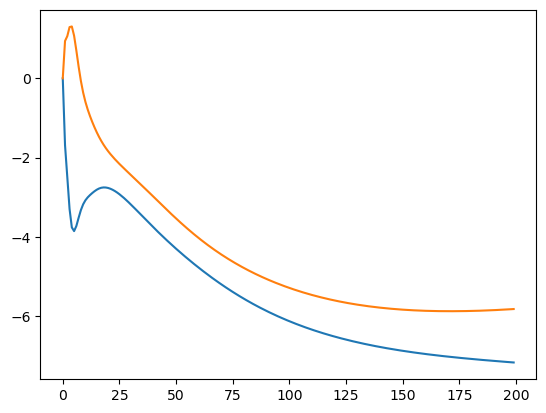

2-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7faf3d880a90>
 PyObject <matplotlib.lines.Line2D object at 0x7faf3d880bb0>

In [1326]:
t_ind = 900
# plot(fs[1:t_ind,10:11] .+ controller.f_des[10:11]')
# plot(-λs[2:t_ind, 1:3]) 
plot(fs[1:200,[3,12]])

In [13]:
vis = Visualizer() 
cur_path = pwd()
cd(joinpath(@__DIR__,"..","src", "a1", "urdf"))
mvis = MechanismVisualizer(A1mech, URDFVisuals(urdfpath), vis)
cd(cur_path)

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat /home/chiyen/.julia/packages/MeshCat/GlCMx/src/visualizer.jl:73


In [1671]:
q_anim = [xs[i,1:19] for i in 1:length(times)-1]
animation = Animation(mvis, times[1:50:end-1], q_anim[1:50:end])
setanimation!(mvis, animation);

In [15]:
render(vis)

MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("world" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("base" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x77, 0x6f, 0x72, 0x6c, 0x64, 0x2f, 0x62, 0x61, 0x73, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("trunk" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x62, 0x61, 0x73, 0x65, 0x2f, 0x74, 0x72, 0x75, 0x6e, 0x6b], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_floating_base" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x61, 0x74, 0x69, 0x6e, 0x67, 0x5f, 0x62, 0x61, 0x73, 0x65], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_2" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x32], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x32], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "RL_hip" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x75, 0x6e, 0x6b, 0x2f, 0x52, 0x4c, 0x5f, 0x68, 0x69, 0x70], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("RL_thigh" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x70, 0x2f, 0x52, 0x4c, 0x5f, 0x74, 0x68, 0x69, 0x67, 0x68], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_RL_thigh_joint" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x68, 0x69, 0x67, 0x68, 0x5f, 0x6a, 0x6f, 0x69, 0x6e, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_17" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x31, 0x37], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x31, 0x37], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))), "RL_calf" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x67, 0x68, 0x2f, 0x52, 0x4c, 0x5f, 0x63, 0x61, 0x6c, 0x66], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("RL_foot" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x6c, 0x66, 0x2f, 0x52, 0x4c, 0x5f, 0x66, 0x6f, 0x6f, 0x74], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("after_RL_foot_fixed" => MeshCat.SceneTrees.SceneNode(nothing, UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72, 0x69, 0x78, 0xc7, 0x40  …  0x66, 0x6f, 0x6f, 0x74, 0x5f, 0x66, 0x69, 0x78, 0x65, 0x64], Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("geometry_19" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x65, 0x6f, 0x6d, 0x65, 0x74, 0x72, 0x79, 0x5f, 0x31, 0x39], UInt8[0x83, 0xa6, 0x6d, 0x61, 0x74, 0x72,

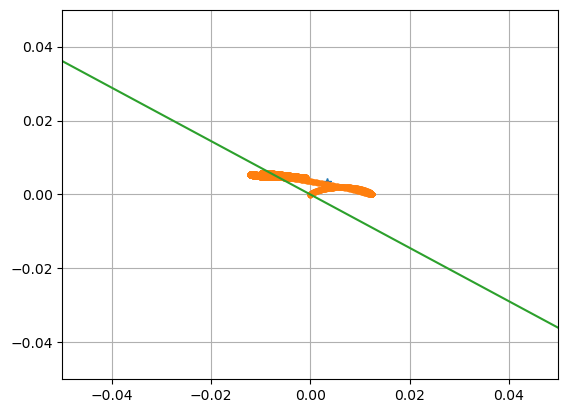

In [1639]:
# plot(com_offset[1],com_offset[2],"o")
plot(x_eq[5], x_eq[6], "*")
plot(ss[1:end,1].-x_eq[5], ss[1:end,2].-x_eq[6],".")
plot(p[[1,10]], p[[2,11]])
xlim([-0.05, 0.05])
ylim([-0.05, 0.05])
grid()

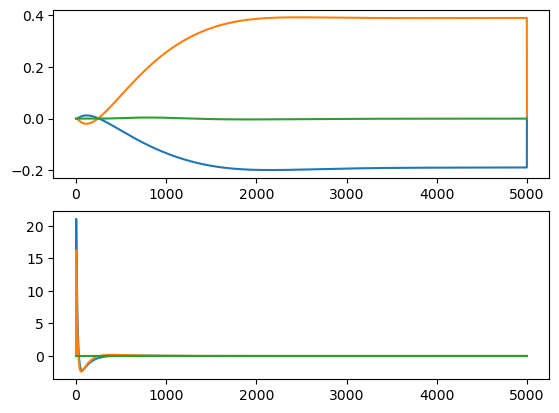

3-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7faf53706130>
 PyObject <matplotlib.lines.Line2D object at 0x7faf537062e0>
 PyObject <matplotlib.lines.Line2D object at 0x7faf53706100>

In [574]:
let 
    ###### Simulation Loop for centroidal model ######
    n = length(x_eq)
    h = 0.001
    tf = 5.0
    times = 0:h:tf
    ϕ_cons = QB.fk_world(x_eq)[foot_indices] # feet constraint 
    ind_fixed = [2,3, 6,7, 10, 11]
    # Loop variables 
    ss = zeros(length(times), 13)
    fs = zeros(length(times), 12)
    δss = zeros(length(times), 12) 
    fs[1,:] = zeros(12)
    ss[1,:] = copy(s_des)
    ss[1,1] = -0.0
    ss[1,11] = ss[1,11] #+ 0.1
    ss[1,12] = ss[1,12] #+ 0.1

    com_offset = [0.01, 0.0, 0.0] # breaks after 0.01 shifts in any direction
    for i in 1:length(times) - 1
        ## get sensor 
        encs = x_eq[8:19]
        quat_meas = UnitQuaternion(ss[i,7:10])
        ## Feedback control 
        fk_cons = QB.fk_world(x_eq)[foot_indices] # feet constraint 
        sn = copy(ss[i,:]) 
        sn[1:3] -= (quat_meas' * com_offset)
        f, δs = qp_controller(model, problem2, controller, sn, encs, fs[i,:], foot_indices)   

        fs[i+1,foot_indices] = f
        δss[i,:] = δs

        ss[i+1,:] = QB.dynamics_rk4(model, ss[i,:], fs[i,:] + controller.f_des, h)
    end
    
    f_sum_des = zeros(length(times),6)
    for i in 1:size(fs,1)
        rot = QB.H'QB.L(ss[i,7:10])*QB.R(ss[i,7:10])'QB.H #Rotation matrix
        r̂1 = QB.hat(rot'*(model.p1-ss[1:3])) # rotate to body frame
        r̂2 = QB.hat(rot'*(model.p2-ss[1:3]))
        r̂3 = QB.hat(rot'*(model.p3-ss[1:3]))
        r̂4 = QB.hat(rot'*(model.p4-ss[1:3]))
        M = [I(3) I(3) I(3) I(3);
             r̂1   r̂2    r̂3   r̂4]
        f_sum_des[i,:] = M*fs[i,:]
    end 
    subplot(2,1,1)
    plot(δss[1:end,7:9])
    
    subplot(2,1,2)
    plot(f_sum_des[:,1:3])
    
    
end